In [12]:
import numpy as np
import pandas as pd
import os
import argparse

import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

from scipy.stats import pearsonr, linregress

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

def autopct_format(values):
    def my_format(pct):
        absolute = round(pct / 100. * sum(values))
        return f"{absolute} ({pct:.1f}%)"
    return my_format

In [13]:
path = "D:\\JoanFR_Sano\Glioblastoma_UCSF-PDGM_v3-20230111"
fmt = 'svg'

<>:1: SyntaxWarning: invalid escape sequence '\G'
<>:1: SyntaxWarning: invalid escape sequence '\G'
C:\Users\user\AppData\Local\Temp\ipykernel_9704\1222932226.py:1: SyntaxWarning: invalid escape sequence '\G'
  path = "D:\\JoanFR_Sano\Glioblastoma_UCSF-PDGM_v3-20230111"


In [14]:
stream_th = 0
figs_folder = f"Demographics-GBM"
os.makedirs(os.path.join(path, "Figures/TDMaps_Grade-IV",figs_folder), exist_ok=True)
daysXmonth = 365/12

TDstats = pd.read_csv(os.path.join(path, f"Figures/TDMaps_Grade-IV/demographics-TDMaps_streamTH-{stream_th}.csv"))

# Apply any filter to the data
TDstats = TDstats.loc[TDstats["Final pathologic diagnosis (WHO 2021)"]=="Glioblastoma  IDH-wildtype"] 
TDstats = TDstats.loc[TDstats["OS"].fillna('unknown')!='unknown']
#TDstats = TDstats.loc[TDstats["MGMT status"].isin(["positive", "negative"])]
#TDstats = TDstats.loc[TDstats["MGMT index"].fillna('unknown')!='unknown']
#TDstats = TDstats.loc[TDstats["1-dead 0-alive"]==1] 

print(TDstats["1-dead 0-alive"].value_counts().sum())
censored = (TDstats["1-dead 0-alive"]==0).sum()
all = TDstats["1-dead 0-alive"].value_counts().sum()
print(f"Precentage of censoring: {round(100*censored/all,2)}%")

367
Precentage of censoring: 39.24%


### If you don't filter for WHO 2021 diagnosis we can obtain the proportion of GBMs and high-grade astrocytomas

ValueError: 'explode' must be of length 'x', not 2

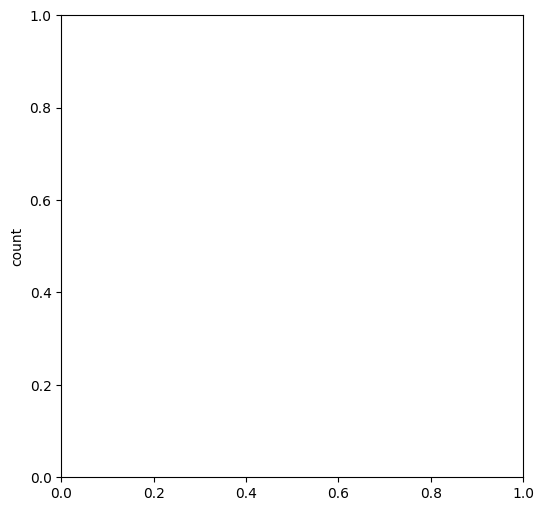

In [39]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))
dt = TDstats["Final pathologic diagnosis (WHO 2021)"].value_counts()
color_types = [ "indianred", "cadetblue"]
dt.plot.pie(
            ax=ax,
            labels=["Glioblastoma IDH-wildtype", "Astrocytoma IDH-mutant"],
            autopct=autopct_format(TDstats["Final pathologic diagnosis (WHO 2021)"].value_counts()),
            colors=color_types,
            explode=[0, 0.1],
            startangle=35
        )
ax.set_title("Diagnosis (WHO 2021)", fontweight='bold')
ax.set_ylabel("")
fig.tight_layout()
fig.savefig(os.path.join(path, f"Figures/TDMaps_Grade-IV/{figs_folder}/diagnosis.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

fig, ax = plt.subplots(1,1, figsize=(5,4))
colors = ["indianred", "cadetblue"]
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(2,), dtype=object)
for i, D in enumerate(["Glioblastoma  IDH-wildtype", "Astrocytoma  IDH-mutant"]):
    diag = TDstats[TDstats["Final pathologic diagnosis (WHO 2021)"]==D]
    mask = ~np.isnan(diag["1-dead 0-alive"]) & ~np.isnan(diag["OS"])
    diag = diag[mask]
    nums[i] = []
    for t in [0,10,20,30,40,50,60,70]:
        nums[i].append((diag["OS"]>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                diag["1-dead 0-alive"]==1, diag["OS"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in diag.loc[diag["1-dead 0-alive"]==0, "OS"].values: # Censoring times
        ax.plot(time[time==t]/daysXmonth, survival_prob[time==t], "|", color=colors[i])

    OS_STATS.extend([(st, ovs) for st, ovs in zip(diag["1-dead 0-alive"]==1, diag["OS"].values)])
    GROUP_STATS.extend([i+1 for ovs in diag["OS"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.70, 0.90, r"$\chi^2 =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")        

for i,t in enumerate([0,10,20,30,40,50,60,70]):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,75, color="black", linewidth=.5)
ax.set_ylim([-.2,1])
ax.set_xlim([-5,75])
ax.set_xticks(range(0,80,10))
ax.set_xticklabels(range(0,80,10))
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(0,70)
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.savefig(os.path.join(path, f"Figures/TDMaps_Grade-IV/{figs_folder}/diagnosis_KM.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

### Age and Sex

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
TDstats["Sex"].value_counts().plot.pie(labels=["Male", "Female"], ax=ax, explode=[0, 0.1], autopct=autopct_format(TDstats["Sex"].value_counts()), colors=['turquoise', 'yellowgreen'])
ax.set_title("Sex", fontweight='bold')
ax.set_ylabel("")
fig.savefig(os.path.join(path, f"Figures/TDMaps_Grade-IV/{figs_folder}/sex.{fmt}"), dpi=300, format=fmt)
plt.close(fig)

fig, ax = plt.subplots(1,1, figsize=(5,4))
colors = ['turquoise', 'yellowgreen']
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(2,), dtype=object)
for i, S in enumerate(["M", "F"]):
    sex = TDstats[TDstats["Sex"]==S]
    mask = ~np.isnan(sex["1-dead 0-alive"]) & ~np.isnan(sex["OS"])
    sex = sex[mask]
    nums[i] = []
    for t in [0,10,20,30,40,50,60,70]:
        nums[i].append((sex["OS"]>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                sex["1-dead 0-alive"]==1, sex["OS"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in sex.loc[sex["1-dead 0-alive"]==0, "OS"].values: # Censoring times
        ax.plot(time[time==t]/daysXmonth, survival_prob[time==t], "|", color=colors[i])

    OS_STATS.extend([(st, ovs) for st, ovs in zip(sex["1-dead 0-alive"]==1, sex["OS"].values)])
    GROUP_STATS.extend([i+1 for ovs in sex["OS"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.70, 0.90, r"$\chi^2 =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")        

for i,t in enumerate([0,10,20,30,40,50,60,70]):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,75, color="black", linewidth=.5)
ax.set_ylim([-.2,1])
ax.set_xlim([-5,75])
ax.set_xticks(range(0,80,10))
ax.set_xticklabels(range(0,80,10))
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(0,70)
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.savefig(os.path.join(path, f"Figures/TDMaps_Grade-IV/{figs_folder}/sex_KM.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

In [16]:
fig, ax = plt.subplots(1,1,figsize=(6, 6))
sns.violinplot(x="Sex", y="Age at MRI", data=TDstats, ax=ax, palette=['turquoise', 'yellowgreen'], split=True, inner="quartile", linewidth=0.75, width=.9)
ax.spines[["top","right"]].set_visible(False)
ax.set_ylim([0,100])
ax.set_ylabel("Age at MRI")
ax.set_xticks([0.25, 0.75], ["Male", "Female"])  
fig.savefig(os.path.join(path, f"Figures/TDMaps_Grade-IV/{figs_folder}/age-sex.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

C:\Users\user\AppData\Local\Temp\ipykernel_9704\3878479956.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Sex", y="Age at MRI", data=TDstats, ax=ax, palette=['turquoise', 'yellowgreen'], split=True, inner="quartile", linewidth=0.75, width=.9)


### MGMT promoter and MGMT index

In [17]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
dt = TDstats["MGMT status"].fillna("Unknown").value_counts()

# Define updated color palette and labels, including "Unknown"
color_types = ["skyblue", "plum", "khaki", "lightgreen"]
labels = ["Positive", "Negative", "Unknown", "Indeterminate"]

# Create pie plot with updated data
dt.plot.pie(
    ax=ax,
    labels=labels,
    autopct=autopct_format(dt),  # Apply formatting function to include absolute counts
    colors=color_types,
    explode=[0.1, 0.1, 0.2, 0.25],  # Set explode for each category
    startangle=180
)

# Customize plot appearance
ax.set_title("MGMT Status", fontweight='bold')
ax.set_ylabel("")
fig.tight_layout()
fig.savefig(os.path.join(path, f"Figures/TDMaps_Grade-IV/{figs_folder}/MGMT-promoter.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

fig, ax = plt.subplots(1,1, figsize=(5,4))
colors = ["skyblue", "plum"]
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(2,), dtype=object)
for i, D in enumerate(["positive", "negative"]):
    diag = TDstats[TDstats["MGMT status"]==D]
    mask = ~np.isnan(diag["1-dead 0-alive"]) & ~np.isnan(diag["OS"])
    diag = diag[mask]
    nums[i] = []
    for t in [0,10,20,30,40,50,60,70]:
        nums[i].append((diag["OS"]>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                diag["1-dead 0-alive"]==1, diag["OS"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in diag.loc[diag["1-dead 0-alive"]==0, "OS"].values: # Censoring times
        ax.plot(time[time==t]/daysXmonth, survival_prob[time==t], "|", color=colors[i])

    OS_STATS.extend([(st, ovs) for st, ovs in zip(diag["1-dead 0-alive"]==1, diag["OS"].values)])
    GROUP_STATS.extend([i+1 for ovs in diag["OS"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.70, 0.90, r"$\chi^2 =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")   
ax.text(0.10, 0.25, f"N={nums[0][0]} ({round(100*nums[0][0]/(nums[0][0]+nums[1][0]),2)} %)", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', color="plum")     
ax.text(0.60, 0.50, f"N={nums[1][0]} ({round(100*nums[1][0]/(nums[0][0]+nums[1][0]),2)} %)", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', color="skyblue")       

for i,t in enumerate([0,10,20,30,40,50,60,70]):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,75, color="black", linewidth=.5)
ax.set_ylim([-.2,1])
ax.set_xlim([-5,75])
ax.set_xticks(range(0,80,10))
ax.set_xticklabels(range(0,80,10))
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(0,70)
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.savefig(os.path.join(path, f"Figures/TDMaps_Grade-IV/{figs_folder}/MGMT-promoter_KM.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

In [18]:
# Count the values and fill NaN with "Unknown"
mgmt_index_counts = TDstats["MGMT index"].fillna("-1").value_counts()

# Sort the indices based on the original 'MGMT index' values
sorted_index = np.sort(mgmt_index_counts.index.to_numpy(dtype=int))

# Plot a barplot with the sorted order
fig, ax = plt.subplots(figsize=(6, 5))
ax.bar(
    sorted_index,
    mgmt_index_counts[np.argsort(mgmt_index_counts.index.to_numpy(dtype=int))],
    edgecolor="black",
    color=["salmon" if ii==0 else 'lightgray' for ii in range(len(sorted_index))]
)
# Add titles and labels
ax.spines[["top","right"]].set_visible(False)
ax.set_title('MGMT Index', fontweight='bold', fontsize=14)
ax.set_xticks(sorted_index)
ax.set_xticklabels(["N.D."]+[str(ii) for ii in sorted_index[1:]])
ax.set_xlabel('MGMT Index', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.spines['bottom'].set_bounds(-1.4,17.4)

# Display the plot
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout for better display
fig.savefig(os.path.join(path, f"Figures/TDMaps_Grade-IV/{figs_folder}/MGMT-index.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

C:\Users\user\AppData\Local\Temp\ipykernel_9704\592543095.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mgmt_index_counts[np.argsort(mgmt_index_counts.index.to_numpy(dtype=int))],


In [19]:
# Filter the data
filtered_data = TDstats.dropna(subset=["OS", "MGMT index"])  # Remove rows with NaN in OS and/or MGMT index
filtered_data = filtered_data[filtered_data["1-dead 0-alive"]==1]  # Only consider status == 1

# Calculate Pearson correlation
mgmt_index = filtered_data["MGMT index"]
ovs = filtered_data["OS"]
pearson_corr, p_value = pearsonr(mgmt_index, ovs)

# Plot
fig, ax = plt.subplots(figsize=(6, 5))
sns.scatterplot(
    x=mgmt_index,
    y=ovs,
    ax=ax,
    color="blue",
    edgecolor="black",
    alpha=0.8
)

# Add the regression line
sns.regplot(
    x=mgmt_index,
    y=ovs,
    ax=ax,
    scatter=False,
    color="red",
    line_kws={"linewidth": 2, "alpha": 0.8}
)

# Annotate Pearson correlation
ax.text(
    0.05, 0.95,
    r'$\rho$'+f" = {pearson_corr:.2f} (p = {p_value:.2g})",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", alpha=0.1), 
    color="red" if p_value<=0.05 else "black"
)

# Customize the plot
ax.set_xticks(sorted_index[1:])
ax.set_xlabel("MGMT Index", fontsize=12)
ax.set_ylabel("Overall Survival (Days)", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

# Show the plot
plt.tight_layout()
fig.savefig(os.path.join(path, f"Figures/TDMaps_Grade-IV/{figs_folder}/MGMT-index_OS.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
colors = ['turquoise', 'plum', 'goldenrod']
OS_STATS = []
GROUP_STATS = []
nums = np.empty(shape=(3,), dtype=object)
for i, D in enumerate(["GTR", "STR", "biopsy"]):
    diag = TDstats[TDstats["EOR"]==D]
    mask = ~np.isnan(diag["1-dead 0-alive"]) & ~np.isnan(diag["OS"])
    diag = diag[mask]
    nums[i] = []
    for t in [0,10,20,30,40,50,60,70]:
        nums[i].append((diag["OS"]>=(t*daysXmonth)).sum())
    
    time, survival_prob, conf_int = kaplan_meier_estimator(
                diag["1-dead 0-alive"]==1, diag["OS"], conf_type="log-log"
            )
    ax.step(time/daysXmonth, survival_prob, where="post", label=f"Male", color=colors[i])
    ax.fill_between(time/daysXmonth, conf_int[0], conf_int[1], alpha=0.15, step="post", color=colors[i])
    for t in diag.loc[diag["1-dead 0-alive"]==0, "OS"].values: # Censoring times
        ax.plot(time[time==t]/daysXmonth, survival_prob[time==t], "|", color=colors[i])
    
    if i<2: # Delete the if clause if you want the multivariate test
        OS_STATS.extend([(st, ovs) for st, ovs in zip(diag["1-dead 0-alive"]==1, diag["OS"].values)])
        GROUP_STATS.extend([i+1 for ovs in diag["OS"].values])

OS_STATS = np.array(OS_STATS, dtype=[('event', 'bool'),('time', 'float')])
chisquared, p_val, stats, covariance = compare_survival(OS_STATS, GROUP_STATS, return_stats=True)
ax.text(0.60, 0.90, r"$\chi^2_{ GTR,STR} =$"+f"{round(chisquared,4)}, \np = {round(p_val,4)}", transform=ax.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.1), color="red" if p_val<=0.05 else "black")        

for i,t in enumerate([0,10,20,30,40,50,60,70]):
    ax.text(t-2, -0.07, f"{nums[0][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[0]) 
    ax.text(t-2, -0.13, f"{nums[1][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[1]) 
    ax.text(t-2, -0.19, f"{nums[2][i]}", transform=ax.transData, fontsize=11, verticalalignment='top', color=colors[2]) 
ax.text(-2, -0.01, "No. at risk", transform=ax.transData, fontsize=11, verticalalignment='top', color="black", fontweight='bold') 
ax.hlines(0,-5,75, color="black", linewidth=.5)
ax.set_ylim([-.26,1])
ax.set_xlim([-5,75])
ax.set_xticks(range(0,80,10))
ax.set_xticklabels(range(0,80,10))
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1])
ax.spines['left'].set_bounds(0,1)
ax.spines['bottom'].set_bounds(0,70)
ax.set_xlabel("Time (months)", fontsize=12)
ax.set_ylabel("Overall survival", fontsize=12)
ax.spines[["top", "right"]].set_visible(False)

fig.savefig(os.path.join(path, f"Figures/TDMaps_Grade-IV/{figs_folder}/EOR_KM.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close(fig)

In [21]:
print(TDstats["Biopsy prior to imaging"].value_counts())
biopsy_counts = TDstats["Biopsy prior to imaging"].value_counts()

fig, ax = plt.subplots(figsize=(6,5))
biopsy_counts.plot.bar(
    ax=ax,
    color=['skyblue', 'lightcoral'],  
    edgecolor='black' 
)
ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks([0,1])
ax.set_xticklabels(["No", "Yes"], rotation=0)
ax.set_ylabel("Count", fontsize=12)
ax.set_title("Biopsy Prior to Imaging", fontsize=14, fontweight='bold')
ax.spines['bottom'].set_bounds(-0.25,1.25)

fig.tight_layout()
fig.savefig(os.path.join(path, f"Figures/TDMaps_Grade-IV/{figs_folder}/prior_biopsy.{fmt}"), dpi=300, format=fmt)
plt.close()

Biopsy prior to imaging
No     312
Yes     55
Name: count, dtype: int64


### Tract Density Indices

In [22]:
# Prepare the figure
fig, ax = plt.subplots(2, 2, figsize=(12, 10), gridspec_kw={"height_ratios": [1, 1]})

# Prepare data for percentile lines
tdi_25, tdi_75 = TDstats["Whole TDMap"].quantile(0.25), TDstats["Whole TDMap"].quantile(0.75)
ltdi_25, ltdi_75 = TDstats["Whole lesion TDMap"].quantile(0.25), TDstats["Whole lesion TDMap"].quantile(0.75)

# Histogram for "Whole TDMap"
tdi = TDstats["Whole TDMap"].dropna()
ax[0, 0].hist(tdi, bins=50, color='lightgray', edgecolor='black', alpha=0.9, density=True)
ax[0, 0].axvline(tdi_25, color='salmon', linestyle="--", linewidth=1.5, label="p Percentile")
ax[0, 0].axvline(tdi_75, color='royalblue', linestyle="--", linewidth=1.5, label="100-p Percentile")
ax[0, 0].fill_betweenx([0, 1], tdi.min(), tdi_25, color="salmon", alpha=0.1, transform=ax[0, 0].get_xaxis_transform())
ax[0, 0].fill_betweenx([0, 1], tdi_25, tdi_75, color="lightgray", alpha=0.1, transform=ax[0, 0].get_xaxis_transform())
ax[0, 0].fill_betweenx([0, 1], tdi_75, tdi.max(), color="royalblue", alpha=0.1, transform=ax[0, 0].get_xaxis_transform())
ax[0, 0].spines[["top", "right", "left"]].set_visible(False)
ax[0, 0].set_yticks([])
ax[0, 0].set_xticks([])
ax[0, 0].legend(loc="upper right", fontsize=12, frameon=False)
ax[0, 0].spines['bottom'].set_bounds(tdi.min(),tdi.max())

# Hide empty subplot (bottom right)
ax[0, 1].axis("off")

# Scatter plot for the relationship between the two variables
ax[1, 0].scatter(
    TDstats["Whole TDMap"], 
    TDstats["Whole lesion TDMap"], 
    alpha=0.7, color="mediumseagreen", edgecolor="black"
)
ax[1, 0].set_xlabel("Tract Density Index (TDI)", fontweight="bold")
ax[1, 0].set_ylabel("Lesion-Tract Density Index (L-TDI)", fontweight="bold")
ax[1, 0].spines[["top", "right"]].set_visible(False)
#ax[1, 0].set_xticklabels([])
#ax[1, 0].set_yticklabels([])
x = TDstats["Whole TDMap"].dropna()
y = TDstats["Whole lesion TDMap"].dropna()
slope, intercept, r_value, _, _ = linregress(x, y)
ax[1, 0].plot(x, slope * x + intercept, color="black", linestyle="-", label=r'$\rho$'+f" = {r_value:.3f}", linewidth=2)
ax[1, 0].legend(loc="upper left", fontsize=12, frameon=False)

# Histogram for "Whole lesion TDMap"
ltdi = TDstats["Whole lesion TDMap"].dropna()
#ax[1,1].invert_xaxis()
ax[1, 1].hist(ltdi, bins=50, color='lightgray', edgecolor='black', alpha=0.9, density=True, orientation='horizontal')
ax[1, 1].axhline(ltdi_25, color='salmon', linestyle="--", linewidth=1.5, label="25th Percentile")
ax[1, 1].axhline(ltdi_75, color='royalblue', linestyle="--", linewidth=1.5, label="75th Percentile")
ax[1, 1].fill_between([0, 0.35], ltdi.min(), ltdi_25, color="salmon", alpha=0.1)
ax[1, 1].fill_between([0, 0.35], ltdi_25, ltdi_75, color="gray", alpha=0.1)
ax[1, 1].fill_between([0, 0.35], ltdi_75, ltdi.max(), color="royalblue", alpha=0.1)
ax[1, 1].spines[["top", "right", "bottom"]].set_visible(False)
ax[1, 1].set_yticks([])
ax[1, 1].set_xticks([])
ax[1, 1].spines['left'].set_bounds(ltdi.min(),ltdi.max())

# Adjust layout
fig.tight_layout()
fig.savefig(os.path.join(path, f"Figures/TDMaps_Grade-IV/{figs_folder}/TDIndices.{fmt}"), dpi=300, format=fmt, transparent=True, bbox_inches='tight')
plt.close()